(<Axes: title={'center': 'Cornerness'}>,
 Text(0.5, 1.0, 'Cornerness'))

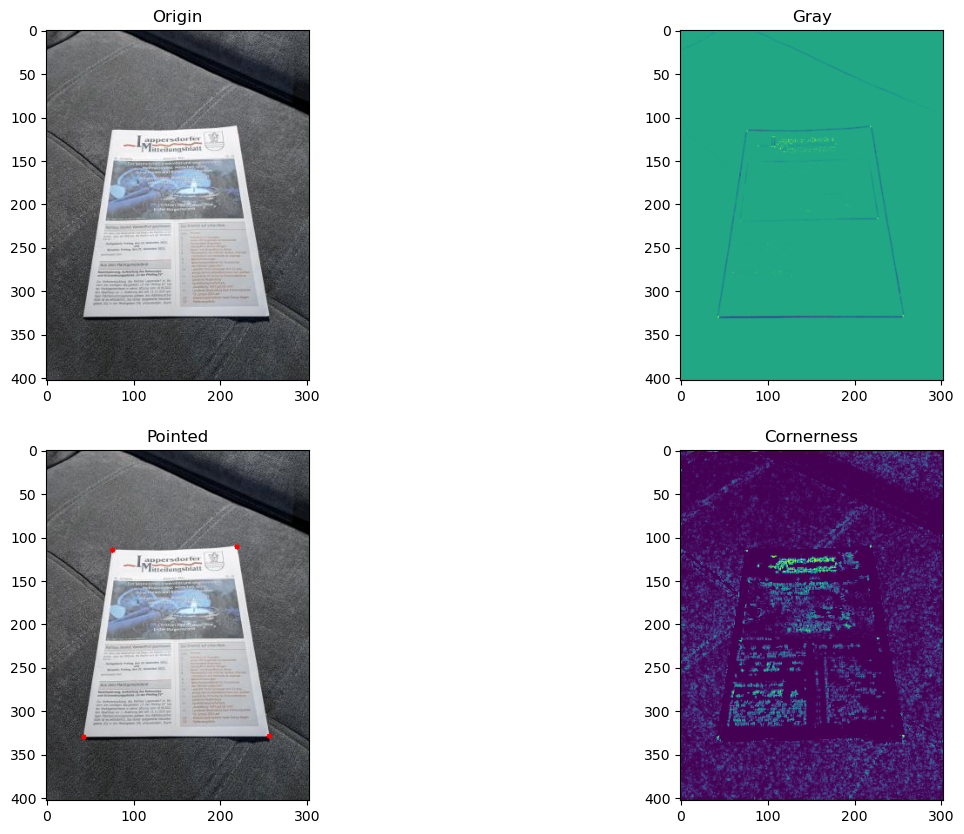

In [36]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Let's read the image
img = cv2.imread('document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(221), plt.imshow(img), plt.title('Origin')
plt.subplot(222), plt.imshow(gray, cmap='gray'), plt.title('Gray')

# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04

cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
plt.imshow(cornerness)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness[cornerness < 0] = 0

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_ritgh = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left     = block[0:quad_size, 0:quad_size]
        quad_top_right    = block[quad_size:, 0:quad_size]
        quad_bottom_left  = block[0:quad_size, quad_size:]
        quad_bottom_right = block[quad_size:, quad_size:]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
                   
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
                   
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
                   
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(223), plt.imshow(out), plt.title('Pointed')
plt.subplot(224), plt.imshow(cornerness), plt.title('Cornerness')
 

### Questions
* Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How? - We will get image with bigger resolution and as a result our corners will be represented by more numbers of pixels.
* If we increased the resolution of the camera, what would you change in the current algorithm? - I guess we need 
 increase "blockSize" paremeter in  cv2.cornerHarris and increse "quad_size" parameter.
